In [132]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sb
from analyze_experiment_in_progress import get_data_from_logs
sb.set()

In [133]:
#bert4rec outperforms everything
#experiment_logs = './results/bert4rec_config_2021_11_04T17_15_31/stdout'

#SALREC-BCE-Great
#experiment_logs = './results/bert4rec_config_2021_11_07T22_26_10/stdout'


#SALREC-Lambdarank 0.157107
#experiment_logs = './results/ml_benchmark20m_2021_11_18T16_38_37/stdout'



#Transformer-Lambdarank 0.1603
#experiment_logs = './results/ml_benchmark20m_2021_11_19T17_43_30/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_23T14_39_04/stdout'

#experiment_logs = './results/ml_benchmark20m_2021_11_25T09_41_35/stdout'

#Fast Lambdarank on dekstop
#experiment_logs = './results/ml_benchmark20m_2021_11_27T23_55_22/stdout'


#Fast Lambdarank on dekstop - 40k, bce slightly better
#experiment_logs = './results/ml_benchmark20m_2021_11_28T08_36_11/stdout'


# Learning rate effects:

# Lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_11_26T10_36_55/stdout"
#BCE
#experiment_logs = "./results/ml_benchmark20m_2021_11_27T11_36_03/stdout"



#Truncation effects: 
#1-20
#experiment_logs = "./results/ml_benchmark20m_2021_11_28T18_14_50/stdout"

#30-120
#experiment_logs = "./results/ml_benchmark20m_2021_11_29T15_12_00/stdout"


#stream -first run: 
#experiment_logs = "./results/steam_benchmark_2021_12_02T16_41_29/stdout"

#steam - num targets
#experiment_logs = "./results/steam_benchmark_2021_12_04T12_47_09/stdout"


#lambda norm effect:
#experiment_logs = "results/ml_benchmark20m_2021_12_02T10_46_35/stdout"

#truncated lambdarank with bce
#experiment_logs = "./results/ml_benchmark20m_2021_12_05T21_30_29/stdout"


#lambdarank-truncated fixed

#experiment_logs = "./results/ml_benchmark20m_2021_12_07T20_37_41/stdout"



#lambdarank-truncated-bce-focus
#experiment_logs = "./results/ml_benchmark20m_2021_12_08T07_39_20/stdout"

#important test
#experiment_logs = "./results/ml_benchmark20m_2021_12_09T09_28_21/stdout"


#12 hours experiment with truncated lambdarank
#experiment_logs = "./results/ml_benchmark20m_2021_12_12T20_24_03/stdout"



#lambda normalization 
#experiment_logs = "./results/lambda_normalization_experiment_2021_12_14T17_33_27/stdout"


#gru4rec experiment
#experiment_logs = "./results/ml_benchmark1m_2021_12_15T18_36_26/stdout"

#sasrec-booking
#experiment_logs = "results/booking_benchmark_2021_12_23T21_31_04/stdout"

#experiment_logs = "./results/booking_benchmark_2021_12_25T17_43_29/stdout"


#top-1 experiment
#experiment_logs = "./results/ml_benchmark20m_2021_12_26T22_18_58/stdout"


#deeper network experiment - sasrec
experiment_logs = "./results/ml_benchmark20m_2021_12_27T19_08_09/stdout"

In [134]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [135]:
data = get_data_from_logs(experiment_logs, 0)

In [136]:
df = pd.DataFrame(data).set_index('model_name')

#df.sort_values('ndcg@10')
df

,metrics_history,num_epochs
model_name,,
SASRec-noreuse-blocks:8-Lambdarank-Truncated:4000-bce_weight:0.975-TimeLimit:1h-lastonly:False,"[{'loss': 6.3214, 'ndcg_at_10': 0.1849, 'val_loss': 7.8079, 'val_ndcg_at_10': 0.0194, 'epoch': 1, 'val_ndcg': 0.01941, 'best_ndcg': 0.01941, 'steps_since_improved': 0.0, 'total_training_time': 69.00155544281006}, {'loss': 8.6286, 'ndcg_at_10': 0.2188, ...",49


0 dict_keys([0])
1 dict_keys([0, 1])


<Figure size 1152x648 with 0 Axes>

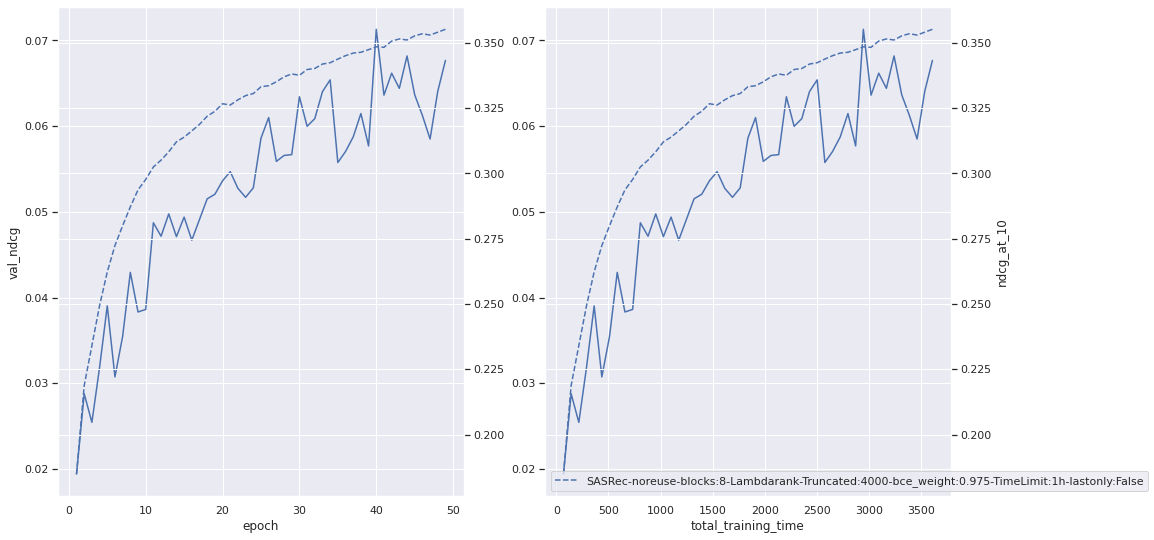

In [137]:
moving_average_steps=1
max_points = 100000


def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(16, 9))

axises = ['epoch', 'total_training_time']

fig, ax = plt.subplots(1, len(axises))
fig.set_figheight(9)
fig.set_figwidth(16)

interesting_models = ['SASRec-noreuse-blocks:8-Lambdarank-Truncated:4000-bce_weight:0.975-TimeLimit:1h-lastonly:False']
second_metrics = {}

for recommender in data:
    if recommender['model_name'] not in interesting_models:
        continue
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        metric_name = 'val_ndcg'
        second_metric_name = 'ndcg_at_10'
        metric = moving_average(get_metric(history, metric_name), moving_average_steps)[:max_points]
        if second_metric_name != None:
            second_metric = moving_average(get_metric(history, second_metric_name), moving_average_steps)[:max_points]
        #success = get_metric(history, 'Success_at_4')
        #val_success = moving_average(get_metric(history, 'val_Success_at_4'), 5)
        
        #plt.plot(val_success, label=recommender['model_name'] + "val_sps")
        #plt.plot(success, label=recommender['model_name'] + "sps")
        for axis_num in range(len(axises)):
            axis_name = axises[axis_num]
            axis = get_metric(history, axis_name)[moving_average_steps - 1:][:max_points]
            ax[axis_num].plot(axis, metric,label=recommender['model_name'])
            
            ax[axis_num].set_xlabel(axis_name)
            if axis_num == 0:
                ax[axis_num].set_ylabel(metric_name)
            
            if (second_metric_name != None):
                if axis_num not in second_metrics:
                    second_metrics[axis_num] = ax[axis_num].twinx()
                    print(axis_num, second_metrics.keys())
                ax2 = second_metrics[axis_num]
                if axis_num == 1:
                    ax2.set_ylabel(second_metric_name)
                ax2.plot(axis, second_metric, '--', label=recommender['model_name'],)

            
        #plt.plot(ndcg, label=recommender['model_name'] + "ndcg")
        #plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


### len(metric), len(metric) - np.argmax(metric) - 1

In [45]:
np.argmax(metric)

76